<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/cnn-experiment/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

Instructions on how to run on an ESP32 are here: https://github.com/lisaong/stackup-workshops/tree/master/mask-or-not

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [3]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

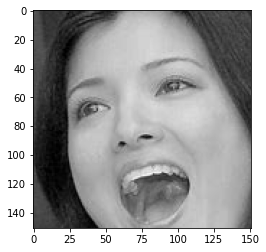

In [4]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [5]:
detect(face_cascade, './data/mask/1.jpg')

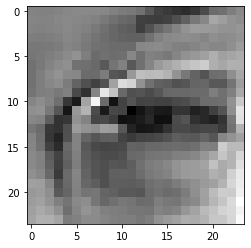

In [6]:
detect(eye_cascade, './data/mask/1.jpg')

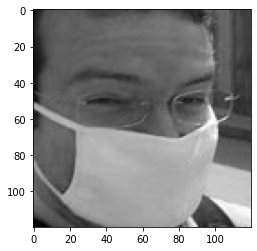

In [7]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

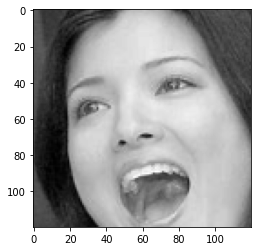

In [8]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

10.jpg


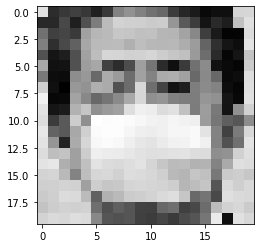

4.jpg


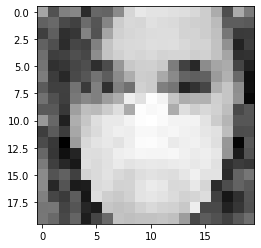

7.jpg


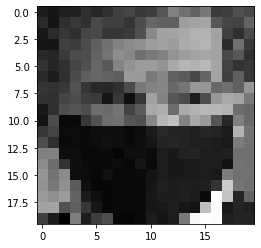

9.jpg


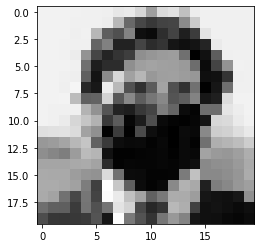

8.jpg


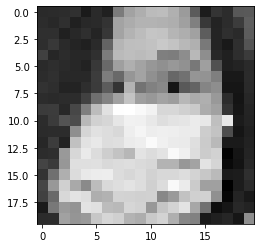

2.jpg


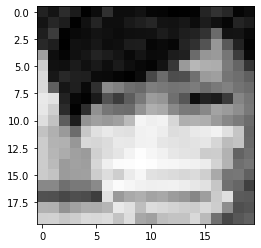

3.jpg


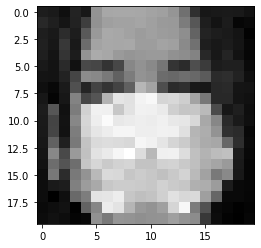

6.jpg


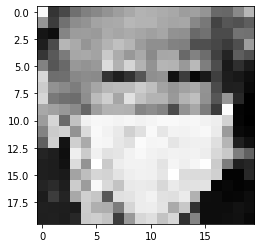

5.jpg


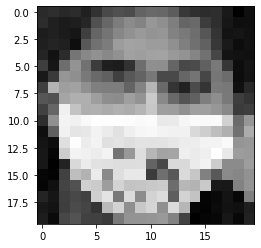

1.jpg


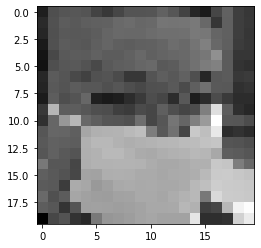

(10, 20, 20)

In [9]:
# Reduce to a small data size so that PCA and the model can fit on ESP32's memory
OUTPUT_SIZE = (20, 20)

def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=OUTPUT_SIZE)))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

10.jpg


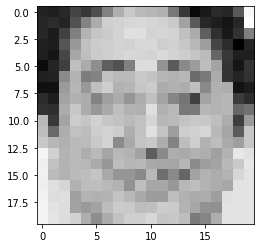

4.jpg


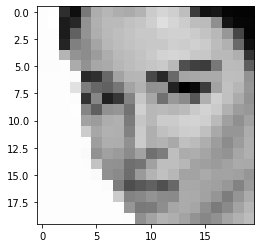

7.jpg


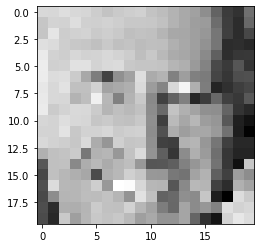

9.jpg


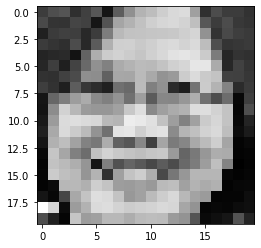

8.jpg


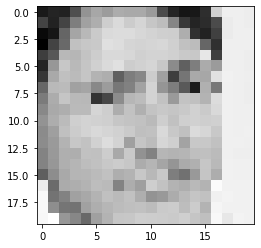

2.jpg


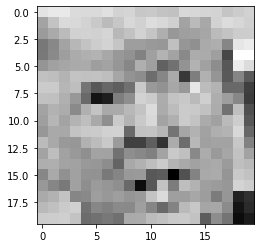

3.jpg


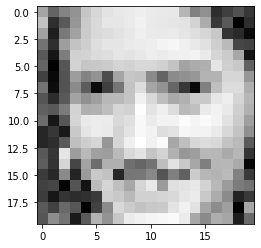

6.jpg


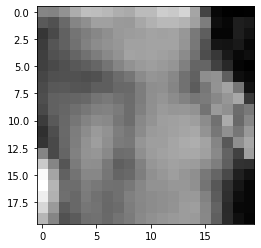

5.jpg


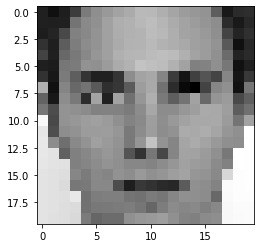

1.jpg


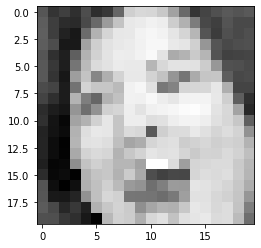

(10, 20, 20)

In [10]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [11]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [12]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 20, 20)

In [13]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 400)

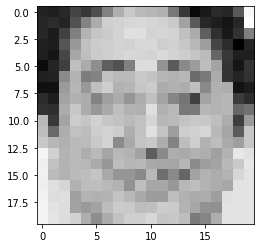

In [14]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [15]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.2410692 , 0.17977598, 0.11575162, 0.09174068, 0.05737947,
       0.05486139, 0.03776564, 0.03400192, 0.03110804, 0.0246079 ,
       0.02224598, 0.01954237, 0.01771666, 0.01610575, 0.01423234])

In [16]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

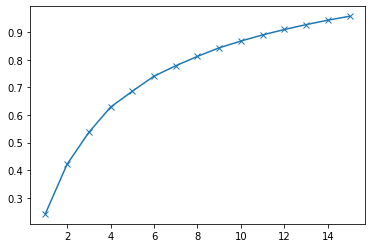

In [17]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [18]:
# choose 7 features
pca = PCA(n_components=7)
Z = pca.fit_transform(X_scaled)

In [19]:
# let's do a pairplot
# df = pd.DataFrame(Z)
# df['label'] = labels
# sns.pairplot(df, hue='label')

In [20]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [23]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Neural Networks

In [24]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mlp.h5', save_best_only=True)

mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=80,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop, checkpoint])

Epoch 1/80
3/3 [==============================] - 0s 71ms/step - loss: 0.9089 - accuracy: 0.4667 - val_loss: 1.0800 - val_accuracy: 0.6000
Epoch 2/80
3/3 [==============================] - 0s 15ms/step - loss: 0.8792 - accuracy: 0.4667 - val_loss: 1.0602 - val_accuracy: 0.6000
Epoch 3/80
3/3 [==============================] - 0s 15ms/step - loss: 0.8586 - accuracy: 0.4667 - val_loss: 1.0393 - val_accuracy: 0.6000
Epoch 4/80
3/3 [==============================] - 0s 19ms/step - loss: 0.8308 - accuracy: 0.4667 - val_loss: 1.0211 - val_accuracy: 0.6000
Epoch 5/80
3/3 [==============================] - 0s 16ms/step - loss: 0.8098 - accuracy: 0.4667 - val_loss: 1.0015 - val_accuracy: 0.6000
Epoch 6/80
3/3 [==============================] - 0s 16ms/step - loss: 0.7921 - accuracy: 0.4667 - val_loss: 0.9825 - val_accuracy: 0.6000
Epoch 7/80
3/3 [==============================] - 0s 16ms/step - loss: 0.7698 - accuracy: 0.4667 - val_loss: 0.9651 - val_accuracy: 0.6000
Epoch 8/80
3/3 [===========

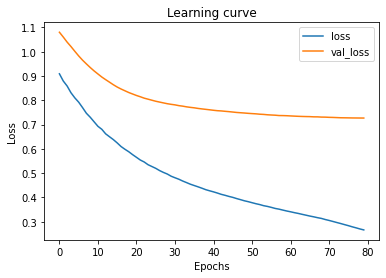

In [26]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [27]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [28]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Convolutional Neural Networks

10.jpg


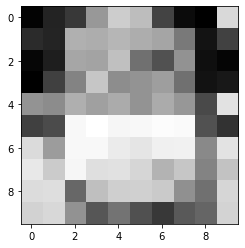

4.jpg


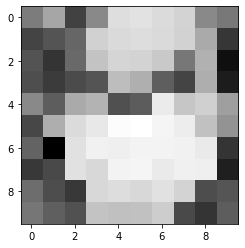

7.jpg


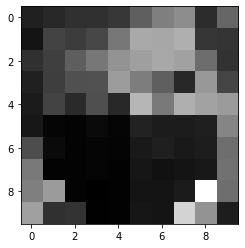

9.jpg


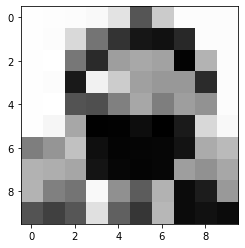

8.jpg


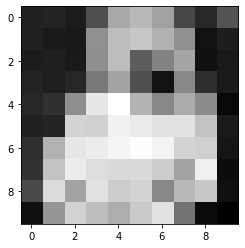

2.jpg


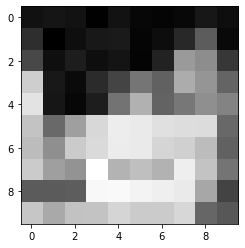

3.jpg


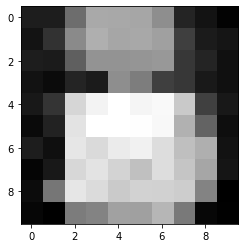

6.jpg


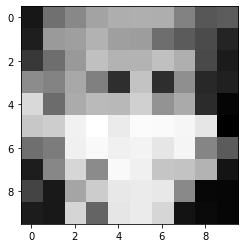

5.jpg


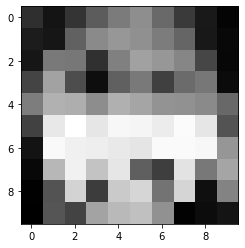

1.jpg


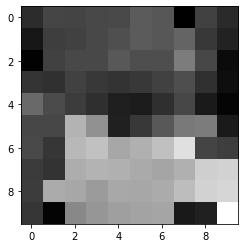

10.jpg


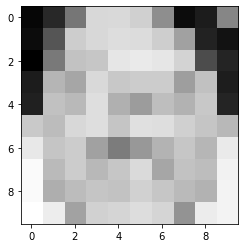

4.jpg


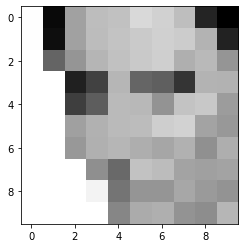

7.jpg


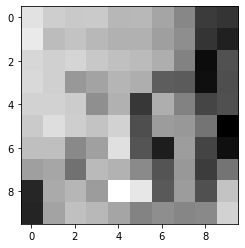

9.jpg


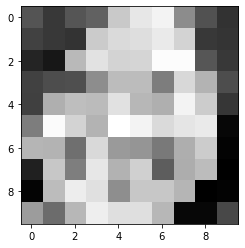

8.jpg


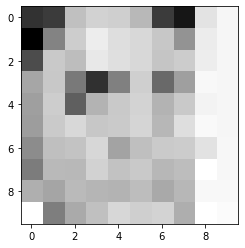

2.jpg


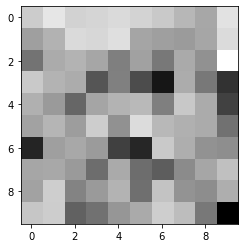

3.jpg


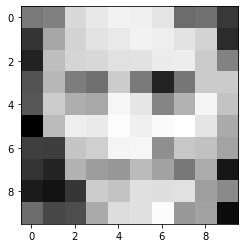

6.jpg


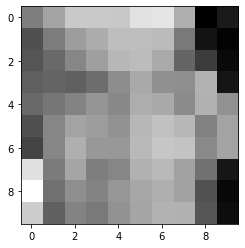

5.jpg


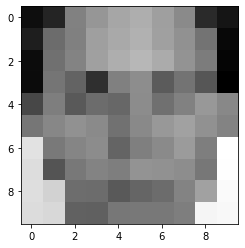

1.jpg


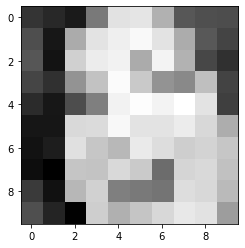

In [29]:
OUTPUT_SIZE = (10, 10)
images_mask = get_image_data('mask')
images_nomask = get_image_data('no_mask')
images = np.vstack([images_nomask, images_mask])

X_cnn = images.reshape(-1, images.shape[1]*images.shape[2])

In [30]:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X_cnn)

X_scaled_reshape = X_scaled.reshape(-1, images.shape[1], images.shape[2], 1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshape, y, 
                                                    random_state=42, stratify=y)
X_train.shape

(15, 10, 10, 1)

In [31]:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
cnn = tf.keras.Sequential()
cnn.add(layers.SeparableConv2D(5, 3, 
        input_shape=(X_train.shape[1],X_train.shape[2], 1), activation='relu'))
#cnn.add(layers.MaxPool2D())
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 8, 8, 5)           19        
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 321       
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn.h5', save_best_only=True)

cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, batch_size=5, epochs=30,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop, checkpoint])

Epoch 1/30
3/3 [==============================] - 0s 42ms/step - loss: 0.6776 - accuracy: 0.4667 - val_loss: 0.5840 - val_accuracy: 0.8000
Epoch 2/30
3/3 [==============================] - 0s 15ms/step - loss: 0.6586 - accuracy: 0.4667 - val_loss: 0.5823 - val_accuracy: 0.8000
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 0.6416 - accuracy: 0.5333 - val_loss: 0.5826 - val_accuracy: 0.8000
Epoch 4/30
3/3 [==============================] - 0s 13ms/step - loss: 0.6297 - accuracy: 0.5333 - val_loss: 0.5828 - val_accuracy: 0.8000
Epoch 5/30
3/3 [==============================] - 0s 11ms/step - loss: 0.6168 - accuracy: 0.5333 - val_loss: 0.5832 - val_accuracy: 0.8000


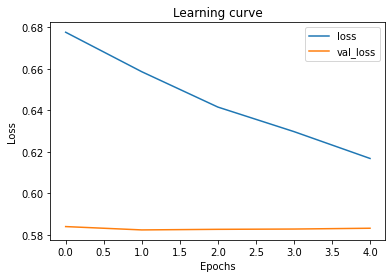

In [33]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [34]:
y_pred_cnn = cnn.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



Comparison to MLP:
```
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5
```

## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('cnn.tflite', 'wb').write(tflite_model)

3212

In [36]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='cnn.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [37]:
!pip install tinymlgen

In [38]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(cnn)

# input should be flattened like this:
#   image_width * image_height * channels
# Ref: https://github.com/tensorflow/tensorflow/blob/59c06b9016700dbf1ab0cefc062d247345cdd0f0/tensorflow/lite/micro/examples/person_detection/image_provider.cc
input_shape = OUTPUT_SIZE[0]*OUTPUT_SIZE[1]*1

with open('cnn.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define NUMBER_OF_INPUTS {input_shape}\n')
  f.write(f'#define NUMBER_OF_OUTPUTS {cnn.get_output_shape_at(0)[1]}\n')

In [39]:
with open('cnn.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0xba, 0xf9, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x1c, 0x0c, 0x00, 0x00, 0x30, 0x06, 0x00, 0x00, 0x18, 0x06, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0e, 0x00, 0x00, 0x00, 0x08, 0x06, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0xec, 0x05, 0x00, 0x00, 0xcc, 0x05, 0x00, 0x00, 0xbc, 0x00, 0x00, 0x00, 0xa8, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x68, 0xf4, 0xff, 0xff, 0x6c, 0xf4, 0xff, 0xff, 0x70, 0xf4, 0xff, 0xff, 0x74, 0xf4, 0xff, 0xff, 0x78, 0xf4,

## Port PCA to Arduino

https://eloquentarduino.github.io/2020/06/arduino-dimensionality-reduction-pca-for-machine-learning-projects/

In [40]:
!pip install micromlgen

In [41]:
import micromlgen

c_code = micromlgen.port(pca)
with open('pca.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define PCA_INPUT_SIZE {OUTPUT_SIZE[0]*OUTPUT_SIZE[1]}\n')

In [42]:
with open('pca.h', 'r') as f:
  print(f.read())

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[7] = { 0 };
                        u[0] = dot(x,   0.013539368423  , 0.042927736284  , 0.043397122529  , 0.042278928073  , 0.056105328146  , 0.043547717292  , 0.041969118802  , 0.025986796154  , 0.007281403197  , -0.006333450198  , -0.019197428561  , 0.001874912373  , 0.017567526403  , 0.019410842004  , 0.036040609269  , 0.046554248704  , 0.036967254933  , 0.043620611935  , 0.020712146338  , 0.016623270066  , 0.033994375252  , 0.040538394059  , 0.049690915688  , 0.053989491655  , 0.04572123327  , 0.042415781678  , 0.023890324976  , -0.017161484285  , -0.045344675839  , -0.0485353

In [43]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'tf_filename' : 'cnn.h5', 
    'tflite_filename': 'cnn.tflite',
    'h_filename' : 'cnn.h',
    'X_pca_h_filename' : 'pca.h'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))